In [1]:
%matplotlib inline
import json
import glob
import numpy as np
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-4i7qijhr because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
gray = (167/255, 168/255, 170/255, 1)
red = (179/255, 27/255, 27/255, 1)
blue = (0,47/255, 108/255,1)
markersize=20

# Mean Plots

In [3]:
combinedOutputs = "combinedOutputsThreeDots/combinedOutputs"

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Ttest_indResult(statistic=-17.704397779532286, pvalue=7.814514366633478e-13)
Ttest_indResult(statistic=-11.395250549674635, pvalue=1.154819777640582e-09)
Ttest_indResult(statistic=-9.672602686832722, pvalue=1.486946948927719e-08)
Ttest_indResult(statistic=-4.777242151546953, pvalue=0.00015070396145130575)
Ttest_indResult(statistic=-0.5825272576431278, pvalue=0.5674378347468575)


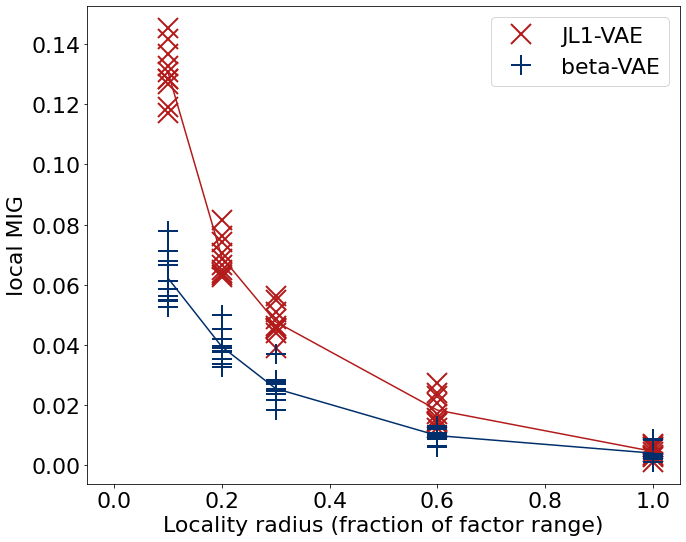

Ttest_indResult(statistic=-16.789371653563684, pvalue=1.928526209914872e-12)
Ttest_indResult(statistic=-8.026054811595529, pvalue=2.339747503423494e-07)
Ttest_indResult(statistic=-8.593351860494371, pvalue=8.717845258509689e-08)
Ttest_indResult(statistic=-8.071506177691994, pvalue=2.1585112748933885e-07)
Ttest_indResult(statistic=-1.0135670130761905, pvalue=0.32422082364394744)


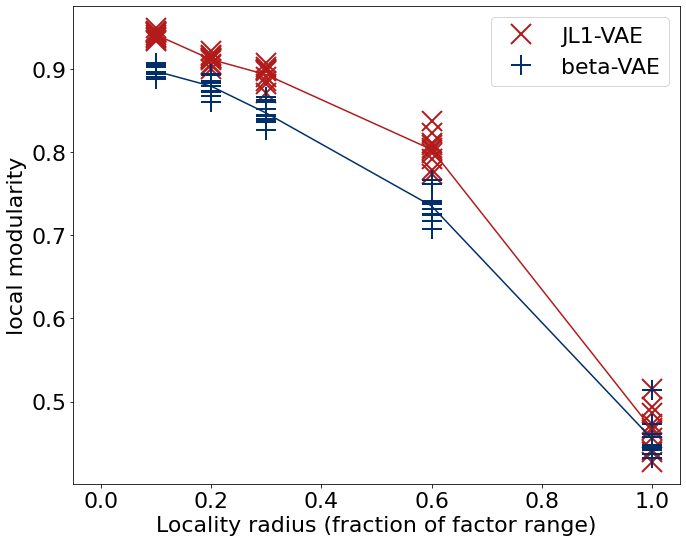

In [4]:
# Gather evaluation results
evaluation_result_template = "{}/metrics/{}/results/aggregate/evaluation.json"
dataset="threeDots"
experiment_output_path = f"../{combinedOutputs}/{dataset}"
for metric, metvalname in [("local_mig","evaluation_results.local_discrete_migs_samples"), 
               ("local_modularity","evaluation_results.local_modularity_scores_samples")]:
    for latdim in ["10"]:
      f = plt.figure(figsize=(10,8))
      for bind, beta in enumerate(["4"]):
        experiment_names = [f"defaultConv_lone_beta{beta}_0000_ica0_1000_lat{latdim}_batch64_lr0_00??_anneal100000",
                            f"defaultConv_lone_beta{beta}_0000_ica0_0000_lat{latdim}_batch64_lr0_00??_anneal100000"
                           ]
        data = []
        for enind, experiment_name in enumerate(experiment_names):
            if enind==1:
                color=blue
                marker="+"
                label="beta-VAE"
            elif enind==0:
                color=red
                marker="x"
                label="JL1-VAE"
            else:
                color=red
                marker="x"
                label="JL1-VAE"
            evaluation_filepaths = glob.glob(f"{experiment_output_path}/{experiment_name}/*/metrics/{metric}*/results/aggregate/evaluation.json")
            for ind, filename in enumerate(evaluation_filepaths):
                #print(filename)
                evaluation_results = json.loads(
                        open(filename, "r").read())
                locality = float(evaluation_results["evaluation_config.local_sample_factors.locality_proportion"])
                met_samps = evaluation_results[metvalname]
                data.append((label, locality, np.mean(met_samps)))
                if bind == 0 and ind == 0 and enind < 2:
                    plt.plot(locality, np.mean(met_samps), markerfacecolor=(1, 1, 1, 0), markeredgecolor=color, markeredgewidth=2, marker=marker,label=label, markersize=markersize,linestyle="None" )
                else:
                    plt.plot(locality, np.mean(met_samps), markerfacecolor=(1, 1, 1, 0), markeredgecolor=color, markeredgewidth=2, marker=marker, markersize=markersize,linestyle="None" )
        plt.ylabel(metric.replace("_"," ").replace("mig","MIG"))
        plt.xlabel("Locality radius (fraction of factor range)");
        plt.xlim(-0.05,1.05)

      import scipy.stats
      avgBetaMetVals = []
      avgLirjMetVals = []
      allLocalities = [0.1, 0.2, 0.3, 0.6, 1.0]
      for desiredLocality in allLocalities:
        betametvals = [metval for (label, locality, metval) in data if label == "beta-VAE" and locality == desiredLocality]
        lirjmetvals = [metval for (label, locality, metval) in data if label == "JL1-VAE" and locality == desiredLocality]
        avgBetaMetVals.append(np.mean(betametvals))
        avgLirjMetVals.append(np.mean(lirjmetvals))
        print(scipy.stats.ttest_ind(betametvals, lirjmetvals))
      plt.plot(allLocalities, avgLirjMetVals, color=red)
      plt.plot(allLocalities, avgBetaMetVals, color=blue)
      plt.legend()
      plt.tight_layout()
      f.savefig(f"threeDots_{metric}_varyingRho.png")
      plt.show();plt.close();